In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers

2022-04-09 02:27:52.796765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-09 02:27:52.796800: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
data=yf.download('0017.hk')

[*********************100%***********************]  1 of 1 completed


In [4]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [5]:
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2010-03-25,51.959129,52.710182,51.344631,52.300514,29.860739,2536219.0,52.493969,52.328966,55.096356,-57.575865,-59.459566,-0.751053,-0.477943,52.058910,51.053067,1.005843,1.365551,6.821374,16.425878,53.392956
2010-03-26,52.095684,53.802620,52.027409,53.392956,30.484467,2510249.0,52.653283,52.425692,66.728957,-16.666641,-16.666641,0.955883,1.160717,52.264148,51.226392,1.037756,1.775211,35.279811,28.350674,53.666065
2010-03-29,53.461231,53.939175,53.461231,53.666065,30.640394,2631978.0,52.664662,52.590696,69.066249,-10.526300,-10.526300,0.068275,1.980045,52.479827,51.407108,1.072719,0.546219,40.712074,31.034403,53.188122
2010-03-30,53.256401,54.075729,52.915012,53.188122,30.367508,3142411.0,52.823976,52.698801,60.402809,-32.500024,-32.500024,0.955883,1.297268,52.588796,51.539035,1.049760,1.160717,19.626336,22.289705,51.890854
2010-03-31,52.641903,53.256401,51.686020,51.890854,29.626841,3351421.0,52.789838,52.693112,43.230895,-79.999888,-79.999888,-0.204830,-0.068275,52.481420,51.565096,0.916324,1.570381,-19.610331,2.111758,52.163963


In [6]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [7]:
X=sc.fit_transform(data.drop('Prediction',1))
Y = data["Prediction"].values.reshape(-1,1)
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(2221, 1, 19) (2221, 1) (247, 1, 19) (247, 1)


/tmp/ipykernel_19672/2420511516.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [8]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l2(0.01)
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

2022-04-09 02:28:05.599907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-09 02:28:05.600165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-09 02:28:05.600215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-09 02:28:05.600243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-09 02:28:05.600268: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [9]:
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=5,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
y_pred = model_tech.predict(X_test)

Epoch 1/300
400/400 [==============================] - 5s 6ms/step - loss: 298.4837 - val_loss: 11.9751
Epoch 2/300
400/400 [==============================] - 2s 4ms/step - loss: 9.0376 - val_loss: 6.8119
Epoch 3/300
400/400 [==============================] - 2s 5ms/step - loss: 5.6112 - val_loss: 3.9983
Epoch 4/300
400/400 [==============================] - 2s 4ms/step - loss: 4.0616 - val_loss: 3.0854
Epoch 5/300
400/400 [==============================] - 2s 5ms/step - loss: 3.4518 - val_loss: 2.7674
Epoch 6/300
400/400 [==============================] - 1s 4ms/step - loss: 3.1149 - val_loss: 2.6074
Epoch 7/300
400/400 [==============================] - 1s 3ms/step - loss: 2.8963 - val_loss: 2.5497
Epoch 8/300
400/400 [==============================] - 2s 4ms/step - loss: 2.7588 - val_loss: 2.5762
Epoch 9/300
400/400 [==============================] - 1s 4ms/step - loss: 2.6737 - val_loss: 2.6639
Epoch 10/300
400/400 [==============================] - 1s 4ms/step - loss: 2.6195 - val

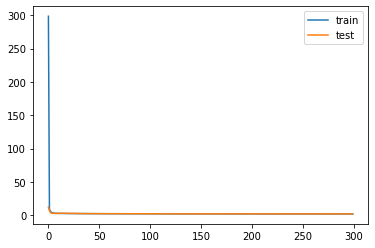

In [10]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

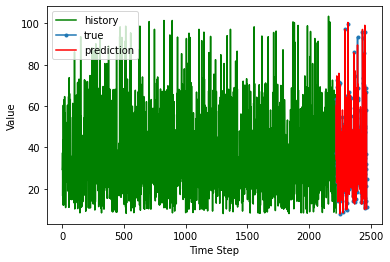

In [11]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

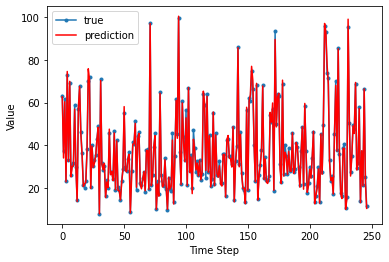

In [12]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [13]:
r2_score(y_test,y_pred)

0.995112364317744

In [14]:
mean_absolute_percentage_error(y_test,y_pred)

0.02878444679320905

In [15]:
mean_squared_error(y_test,y_pred,squared=False)

1.3186550657107192

In [16]:
x_val=data_val.drop('Prediction',1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/tmp/ipykernel_19672/2328949661.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1)


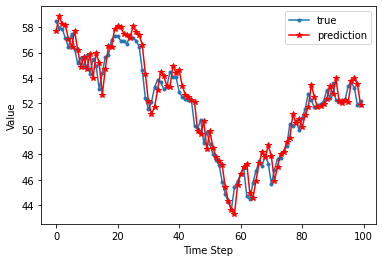

In [17]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [18]:
r2_score(y_val,y_val_pred)

0.9303176764461304

In [19]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.01607685870090615

In [20]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

1.0089663299372669